In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
def initial_value(nx, ny):
 
    # Setting Parameters
    h = 1 / nx
    x = np.linspace(-0.5 * h, h * (nx + 0.5), nx)
    y = np.linspace(-0.5 * h, h * (ny + 0.5), ny)

    pn = 0.5 * (2 * np.random.rand(nx, ny) - 1)

    # Graph of Initial Value
    plt.figure(figsize=(4, 4))
    plt.imshow(pn, interpolation='nearest', cmap='jet',
               extent=[x.min(), x.max(), y.min(), y.max()],
               origin='lower', aspect='auto')
    plt.title('$u(x,y,t=0)$', fontsize=20)
    plt.clim(-1, 1)
    plt.show()

    return x, y, pn

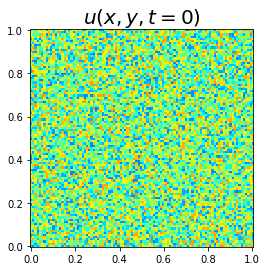

In [3]:
nx = ny = 100
h = 1/nx
h2 = h**2
dt = .1*h**2
eps = 10 * h / (2 * np.sqrt(2) * np.arctanh(0.9))
maxiter = 301
maxtime = dt * maxiter

# Initial condition
x, y, pn = initial_value(nx, ny)

In [4]:
maxtime

0.00301

In [6]:
class FDM(nn.Module):
    def __init__(self, h2, dt, eps, device):
        super(FDM, self).__init__()
        self.delta = torch.Tensor([[[[0., 1., 0.], [1., -4., 1], [0., 1., 0.]]]]).to(device)
        self.pad = nn.ReplicationPad2d(1)
        self.alpha = dt / eps ** 2
        self.beta = dt / h2
    
    def forward(self, x):
        u_pad = self.pad(x)
        diffusion = F.conv2d(u_pad, self.delta)
        x = (1 + self.alpha) * x - self.alpha * x ** 3 + self.beta * diffusion
        return x

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = FDM(h2, dt, eps, device).to(device)
img = torch.FloatTensor(pn).view(-1, 1, nx, ny).to(device)

In [8]:
solutions = []

with torch.no_grad():

    for step in range(maxiter):
        u = model(img)
        img = u # phi^(n+1) <- f(phi^n)
        solutions.append(img.view(nx, ny).cpu().numpy())     

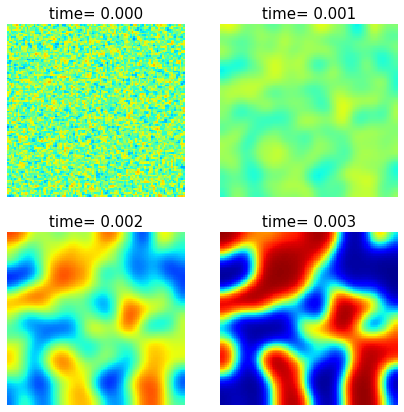

In [9]:
fig = plt.figure(figsize=(7,7))
d = range(221, 225)
timeslot = np.linspace(0, len(solutions)-1, 4)
for i, subp in enumerate(d):
    
    plt.subplot(subp)
    plt.imshow(solutions[int(timeslot[i])], interpolation='nearest', cmap='jet', 
                extent=[x.min(), x.max(), y.min(), y.max()], 
                origin='lower', aspect='auto')
    plt.clim(-1,1)
    plt.axis('off')
    plt.title('time= %.3f' %(dt*timeslot[i]), fontsize=15)

plt.show()